In [95]:
import numpy as np
import scipy.stats as stat
import matplotlib.pyplot as plot
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import plotly.express as px
from copy import deepcopy
from scipy.optimize import minimize
from sklearn import svm

# parameters declaration and data generation
n1, n2, n are w/e in range [100,1000]
q1 is w/e in range [0,1]
mu1,mu2 are w/e 3 dim vectors
sigma is w/e 3x3 matrix

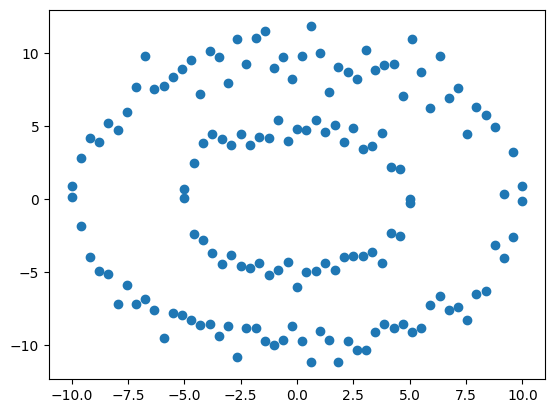

In [114]:
n1 = 100
n2 = 50
R = 10

def gen_noisy_ring(n,R,noise_scale=1):
    noise_ring = stat.norm.rvs(loc=0, scale = noise_scale, size=n)
    x = np.linspace(-R,R,n//2)
    upper_ring = (R**2 - x**2)**0.5
    lower_ring = -upper_ring
    x = np.append(x,x[::-1])
    ring = np.append(upper_ring,lower_ring)
    ring += noise_ring
    return x,ring

x1,y1 = gen_noisy_ring(n1,R,1)
x2,y2 = gen_noisy_ring(n2,R/2,0.5)

x = np.append(x1,x2)
y = np.append(y1,y2)
plot.scatter(x,y)
X = np.array(list(zip(x,y)))

In [130]:
def ker(x,y, q=1):
    return np.exp(-q * np.linalg.norm(x-y,2)**2)
def calc_dot_prod_matrix(X,q=1):
    n = np.shape(X)[0]
    K = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1):
            k_ij = ker(X[i],X[j],q)
            K[i][j] = K[j][i] = k_ij
    return K

def line_between_two_points(x,y,lambd):
    return lambd * x + (1-lambd) * y


# accepts index of element 
def r_square(ind, K, beta):
    return K[ind][ind] - 2 * beta.T @ K[ind] + beta.T @ K @ beta

def wolf_lagr(beta,K):
    return beta.T @ K.diagonal() - beta.T @ K @ beta

q=1
K = calc_dot_prod_matrix(X,q)
n = np.shape(K)[0]
p = 0.5
C = 1 /(n*p)
x0 = np.zeros(n) * 1/n
bounds = list(zip(np.zeros(n), C * np.ones(n)))
minus_lagr = lambda t,K: -wolf_lagr(t,K) 
beta = minimize(minus_lagr, x0, args=(K,),bounds=bounds, constraints=({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1 })).x
sv_ind = []
# print(beta)

for i in range(n):
    if beta[i] > 1e-8:
        sv_ind.append(i)
        # print(beta[i])
print(f"number of support vectors: {len(sv_ind)}\n")

print("sphere radiuses:")
beta_pos = beta[sv_ind]
R = np.zeros(n)
for i in sv_ind:
    R[i] = r_square(i,K,beta)**0.5
print(np.var(R)**0.5)
print(f"percent of BSV: {len(sv_ind) / n}")

number of support vectors: 140

sphere radiuses:
0.24772010530561192
percent of BSV: 0.9333333333333333


In [96]:
clf = svc.predict

In [97]:
clf.fit(X)


TypeError: fit() missing 1 required positional argument: 'y'

# 1. parameters estimations

In [59]:
# n - sample size, p - dimension of each sample's entry
def estimate_mean(data):
    n = np.shape(data)[0]
    return np.sum(data, axis=0) / n

# ( ((n1 - 1) * np.cov(sample1.T) + (n2 - 2) * np.cov(sample2.T)) / (n1 + n2 - 2) )
def estimate_sigma(data1, data2, p=3):
    sigma = np.resize(np.zeros(p**2), new_shape=(p,p))
    for data in [data1, data2]:
        mu_k = estimate_mean(data)
        for l in range(p):
            for j in range(p):
                sigma[l][j] += np.sum((data[:,l] - mu_k[l]) * (data[:,j] - mu_k[j]))
    return sigma / (np.shape(data1)[0] + np.shape(data2)[0] - 2)

def estimate_alpha(sigma, mu1, mu2):
    return np.linalg.solve(sigma, mu1-mu2)

def calc_z(data, alpha):
    z = data @ alpha
    return np.sum(z) / np.shape(z)[0]

def calc_s_z(alpha, sigma):
    return alpha.T @ sigma @ alpha

def classify(data, z1, z2, q1, q2, alpha):
    class_1 = []
    class_2 = []
    class_num = []
    for entry in data:
        if alpha.T @ entry >= (z1 + z2) / 2 + np.log(q2 / q1):
            class_1.append(entry)
            class_num.append(1.)
        else:
            class_2.append(entry)
            class_num.append(2.)
    return class_1, class_2, class_num


est_mu1 = estimate_mean(sample1)
est_mu2 = estimate_mean(sample2)
est_sigma = estimate_sigma(sample1, sample2)
est_alpha = estimate_alpha(est_sigma, est_mu1, est_mu2)

z1 = calc_z(sample1, est_alpha)
z2 = calc_z(sample2, est_alpha)
_, _, pred_class_num = classify(test_sample, z1, z2, q1, q2, est_alpha)

real_class_num = np.concatenate((np.ones(int(n * q1)), 2 * np.ones(int(n * q2))))

print(real_class_num == pred_class_num) 


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


# 2 estimate classification error probability

In [60]:
def mahalanobis_distance(z1, z2, s_z):
    return (z1 - z2)**2 / s_z

def unbiased_mahalanobis_distance(z1, z2, s_z, n1, n2, p=3):
    D = mahalanobis_distance(z1, z2, s_z)
    return (n1 + n2 - p - 3) / (n1 + n2 - 2) * D**2 - p * (1 / n1 + 1 / n2)

s_z = calc_s_z(est_alpha, est_sigma)
D = mahalanobis_distance(z1, z2, s_z)
D_H = unbiased_mahalanobis_distance(z1, z2, s_z, n1, n2)
print(D)
print(D_H)

272.79495950143775
73819.33729943613


In [61]:
K = np.log(q2 / q1)
prob_2_1 = stat.norm.cdf((K - 0.5 * D_H**2 ) / D_H)
prob_1_2 = stat.norm.cdf((-K - 0.5 * D_H**2 ) / D_H)


cl_1, cl_2, pred_class_num_train = classify(np.concatenate((sample1, sample2), axis=0), z1, z2, q1, q2, est_alpha)
table = print_error_table(pred_class_num_train, np.concatenate((np.ones(n1), 2 * np.ones(n2))))

freq_prob_2_1 = table[0][1] / q1
freq_prob_1_2 = table[1][0] / q2


print(f"P(2|1): via freq {freq_prob_2_1}; via mahalanobis dist: {prob_2_1}")
print(f"P(1|2): via freq {freq_prob_1_2}; via mahalanobis dist: {prob_1_2}")


           | predicted 1 | predicted 2
true val 1 |    [0,0]    |   [0,1]
true val 2 |    [1,0]    |   [1,1]

[0.6000000000000004, 0]
[0, 0.4000000000000003]
P(2|1): via freq 0.0; via mahalanobis dist: 0.0
P(1|2): via freq 0.0; via mahalanobis dist: 0.0


# 3 classification of test sample

In [62]:

def print_error_table(predict, actual):
    table = [[0,0],[0,0]]
    n = np.shape(predict)[0]
    for i in range(n):
        if predict[i] == 1. and actual[i] == 1.:
            table[0][0] += 1/n
        elif predict[i] == 2. and actual[i] == 1.:
            table[0][1] += 1/n
        elif predict[i] == 1. and actual[i] == 2.:
            table[1][0] += 1/n
        else:
            table[1][1] += 1/n
    print("           | predicted 1 | predicted 2")
    print("true val 1 |    [0,0]    |   [0,1]")
    print("true val 2 |    [1,0]    |   [1,1]\n")
    for true_vals in table:
        print(true_vals)
    return table

#            | predicted 1 | predicted 2 
# true val 1 |    [0,0]    |   [0,1]
# true val 2 |    [1,0]    |   [1,1]
table = print_error_table(pred_class_num, real_class_num)

           | predicted 1 | predicted 2
true val 1 |    [0,0]    |   [0,1]
true val 2 |    [1,0]    |   [1,1]

[0.6000000000000003, 0]
[0, 0.4000000000000002]


# 4 german dataset task

In [63]:
df = pd.read_csv("german.data", sep = ' ', skipinitialspace=True, header=None, dtype=np.float64)
df = df.drop([25], axis=1)
data = df.to_numpy()
# print(data)
# y = data[:,-1]
# data = np.delete(data, obj=-1, axis=1)

train, test = train_test_split(data, test_size=0.2, random_state=4)

def select_train_by_class(train, clazz):
    train_i = train[train[:,-1] == clazz]
    train_i = np.delete(train_i, obj=-1, axis=1)
    return train_i

def process_test(test):
    test = test[test[:, -1].argsort()] # sort by class value so it's easy to see correctly guessed classes
    n = np.shape(test)[0]
    q1 = np.shape(test[test[:,-1] == 1])[0] / n
    q2 = np.shape(test[test[:,-1] == 2])[0] / n
    test =  np.delete(test, obj=-1, axis=1)
    return test, q1, q2, n
    
def normalize(data):
    from copy import deepcopy
    data_t = deepcopy(data.T)
    for i in range(np.shape(data_t)[0]):
        x = data_t[i,:]
        max = np.max(x)
        min = np.min(x)
        data_t[i,:] = (x - min) / (max - min)
    return data_t.T

train_1 = select_train_by_class(train, 1)
# train_1_normilized = normalize(train_1)
# train_1 = train_1_normilized
n1 = np.shape(train_1)[0]

train_2 = select_train_by_class(train, 2)
n2 = np.shape(train_2)[0]
# train_2_normilized = normalize(train_2)
# train_2 = train_2_normilized 

q1 = n1 / (n1 + n2)
q2 = 1 - q1

test, tru_q1, tru_q2, n = process_test(test)
# test_norm = normalize(test)
# test = test_norm

p = np.shape(train_1)[1]

In [163]:
print(np.shape(train_1))
print(np.shape(train_2))
print(np.shape(real_class_num))
print(q1,q2)
print(tru_q1,tru_q2)


(559, 24)
(241, 24)
(100,)
0.69875 0.30125
0.705 0.295


In [164]:
est_mu1 = estimate_mean(train_1)
est_mu2 = estimate_mean(train_2)
est_sigma = estimate_sigma(train_1, train_2, p=p)
est_alpha = estimate_alpha(est_sigma, est_mu1, est_mu2)

z1 = calc_z(train_1, est_alpha)
z2 = calc_z(train_2, est_alpha)
cl_1, cl_2, pred_class_num = classify(test, z1, z2, q1, q2, est_alpha)

real_class_num = np.concatenate((np.ones(1+int(n * q1)), 2 * np.ones(int(n * q2))))

In [165]:
s_z = calc_s_z(est_alpha, est_sigma)
D = mahalanobis_distance(z1, z2, s_z)
D_H = unbiased_mahalanobis_distance(z1, z2, s_z, n1, n2, p=p)
print(D)
print(D_H)

1.6367857536019372
2.4526180412547984


In [166]:

K = np.log(q2 / q1)
prob_2_1 = stat.norm.cdf((K - 0.5 * D_H**2 ) / D_H)
prob_1_2 = stat.norm.cdf((-K - 0.5 * D_H**2 ) / D_H)

cl_1, cl_2, pred_class_num_train = classify(np.concatenate((train_1, train_2), axis=0), z1, z2, q1, q2, est_alpha)
table = print_error_table(pred_class_num_train, np.concatenate((np.ones(n1), 2 * np.ones(n2))))

freq_prob_2_1 = table[0][1] / q1
freq_prob_1_2 = table[1][0] / q2


print(f"P(2|1): via freq {freq_prob_2_1}; via mahalanobis dist: {prob_2_1}")
print(f"P(1|2): via freq {freq_prob_1_2}; via mahalanobis dist: {prob_1_2}")

           | predicted 1 | predicted 2
true val 1 |    [0,0]    |   [0,1]
true val 2 |    [1,0]    |   [1,1]

[0.6249999999999922, 0.07375000000000004]
[0.1412500000000001, 0.16000000000000011]
P(2|1): via freq 0.1055456171735242; via mahalanobis dist: 0.05828301183898339
P(1|2): via freq 0.4688796680497928; via mahalanobis dist: 0.18854617876434449


## test data classification

In [167]:

#            | predicted 1 | predicted 2 
# true val 1 |    [0,0]    |   [0,1]
# true val 2 |    [1,0]    |   [1,1]
table = print_error_table(pred_class_num, real_class_num)

           | predicted 1 | predicted 2
true val 1 |    [0,0]    |   [0,1]
true val 2 |    [1,0]    |   [1,1]

[0.6300000000000004, 0.06999999999999999]
[0.15000000000000005, 0.15000000000000005]


# pca reduction before classifying

## model data

In [52]:
n1 = np.shape(sample1)[0]
n2 = np.shape(sample2)[0]
n = np.shape(test_sample)[0]
q1 = n1 / (n1 + n2)
q2 = n2 / (n1 + n2)


no_marks = np.concatenate((sample1,sample2,test_sample), axis=0)
print(np.shape(no_marks))


comp = 2
pca = PCA(n_components=comp)
data_pca = pca.fit(no_marks).transform(no_marks)
print(np.shape(data_pca))
train_1 = data_pca[:n1]
train_2 = data_pca[n1:n1+n2]
test = data_pca[n1+n2:]
p = np.shape(train_1)[1]
print(f"explained_variance_ratio: {pca.explained_variance_ratio_}")
print(f"total explained variance in {comp} components: {np.sum(pca.explained_variance_ratio_)}")


est_mu1 = estimate_mean(train_1)
est_mu2 = estimate_mean(train_2)
est_sigma = estimate_sigma(train_1, train_2, p=p)
est_alpha = estimate_alpha(est_sigma, est_mu1, est_mu2)

z1 = calc_z(train_1, est_alpha)
z2 = calc_z(train_2, est_alpha)
cl_1, cl_2, pred_class_num = classify(test, z1, z2, q1, q2, est_alpha)

(600, 3)
(600, 2)
explained_variance_ratio: [0.9754439  0.01863638]
total explained variance in 2 components: 0.9940802775567278


In [53]:
s_z = calc_s_z(est_alpha, est_sigma)
D = mahalanobis_distance(z1, z2, s_z)
D_H = unbiased_mahalanobis_distance(z1, z2, s_z, n1, n2, p=p)
print(D)
print(D_H)

663.5258465537715
437614.324251456


In [54]:

K = np.log(q2 / q1)
prob_2_1 = stat.norm.cdf((K - 0.5 * D_H**2 ) / D_H)
prob_1_2 = stat.norm.cdf((-K - 0.5 * D_H**2 ) / D_H)

cl_1, cl_2, pred_class_num_train = classify(np.concatenate((train_1, train_2), axis=0), z1, z2, q1, q2, est_alpha)
table = print_error_table(pred_class_num_train, np.concatenate((np.ones(n1), 2 * np.ones(n2))))

freq_prob_2_1 = table[0][1] / q1
freq_prob_1_2 = table[1][0] / q2


print(f"P(2|1): via freq {freq_prob_2_1}; via mahalanobis dist: {prob_2_1}")
print(f"P(1|2): via freq {freq_prob_1_2}; via mahalanobis dist: {prob_1_2}")

           | predicted 1 | predicted 2
true val 1 |    [0,0]    |   [0,1]
true val 2 |    [1,0]    |   [1,1]

[0.6000000000000004, 0]
[0, 0.4000000000000003]
P(2|1): via freq 0.0; via mahalanobis dist: 0.0
P(1|2): via freq 0.0; via mahalanobis dist: 0.0


In [55]:
real_class_num = np.concatenate((np.ones(int(n * q1)), 2 * np.ones(int(n * q2))))
table = print_error_table(pred_class_num, real_class_num)

           | predicted 1 | predicted 2
true val 1 |    [0,0]    |   [0,1]
true val 2 |    [1,0]    |   [1,1]

[0.6000000000000003, 0]
[0, 0.4000000000000002]


In [56]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    data_pca,
    labels=labels,
    dimensions=range(comp),
    color=np.concatenate((np.ones(n1), 2 * np.ones(n2), real_class_num))
)
fig.update_traces(diagonal_visible=False)
fig.show()

## german dataset

In [109]:
N = np.shape(data)[0]
train = data[:int(N*0.8)]
test = data[int(N*0.8):]
train_1 = select_train_by_class(train, 1)
n1 = np.shape(train_1)[0]
train_2 = select_train_by_class(train, 2)
n2 = np.shape(train_2)[0]
test, tru_q1, tru_q2, n = process_test(test)
q1 = n1 / (n1 + n2)
q2 = 1 - q1

no_marks = np.concatenate((train_1,train_2,test), axis=0)
print(np.shape(no_marks))


comp = 5
pca = PCA(n_components=comp)
data_pca = pca.fit(no_marks).transform(no_marks)
print(np.shape(data_pca))
train_1 = data_pca[:n1]
train_2 = data_pca[n1:n1+n2]
test = data_pca[n1+n2:]
p = np.shape(train_1)[1]
print(f"explained_variance_ratio: {pca.explained_variance_ratio_}")
print(f"total explained variance in {comp} components: {np.sum(pca.explained_variance_ratio_)}")

est_mu1 = estimate_mean(train_1)
est_mu2 = estimate_mean(train_2)
est_sigma = estimate_sigma(train_1, train_2, p=p)
est_alpha = estimate_alpha(est_sigma, est_mu1, est_mu2)

z1 = calc_z(train_1, est_alpha)
z2 = calc_z(train_2, est_alpha)
cl_1, cl_2, pred_class_num = classify(test, z1, z2, q1, q2, est_alpha)


(1000, 24)
(1000, 5)
explained_variance_ratio: [0.79426932 0.12054817 0.07462957 0.00251035 0.00147001]
total explained variance in 5 components: 0.9934274131021877


In [110]:
s_z = calc_s_z(est_alpha, est_sigma)
D = mahalanobis_distance(z1, z2, s_z)
D_H = unbiased_mahalanobis_distance(z1, z2, s_z, n1, n2, p=p)
print(D)
print(D_H)


1.0543102552080763
1.0733792861415328


In [111]:

K = np.log(q2 / q1)
prob_2_1 = stat.norm.cdf((K - 0.5 * D_H**2 ) / D_H)
prob_1_2 = stat.norm.cdf((-K - 0.5 * D_H**2 ) / D_H)

cl_1, cl_2, pred_class_num_train = classify(np.concatenate((train_1, train_2), axis=0), z1, z2, q1, q2, est_alpha)
table = print_error_table(pred_class_num_train, np.concatenate((np.ones(n1), 2 * np.ones(n2))))

freq_prob_2_1 = table[0][1] / q1
freq_prob_1_2 = table[1][0] / q2


print(f"P(2|1): via freq {freq_prob_2_1}; via mahalanobis dist: {prob_2_1}")
print(f"P(1|2): via freq {freq_prob_1_2}; via mahalanobis dist: {prob_1_2}")

           | predicted 1 | predicted 2
true val 1 |    [0,0]    |   [0,1]
true val 2 |    [1,0]    |   [1,1]

[0.6274999999999922, 0.07375000000000004]
[0.18000000000000013, 0.11875000000000008]
P(2|1): via freq 0.10516934046345816; via mahalanobis dist: 0.09149322247810726
P(1|2): via freq 0.6025104602510466; via mahalanobis dist: 0.6018878400683775


## test data classification

In [112]:
real_class_num = np.concatenate((np.ones(1+int(n * tru_q1)), 2 * np.ones(int(n * tru_q2))))
table = print_error_table(pred_class_num, real_class_num)

           | predicted 1 | predicted 2
true val 1 |    [0,0]    |   [0,1]
true val 2 |    [1,0]    |   [1,1]

[0.6250000000000004, 0.075]
[0.14000000000000004, 0.16000000000000006]


In [114]:
import plotly.express as px
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    data_pca,
    labels=labels,
    dimensions=range(4),
    color=data[:,-1]
)
fig.update_traces(diagonal_visible=False)
fig.show()